# Association Rule Mining in R

To be able to run the code in this tutorial and complete your HW/lab assignments, you need to install and library the following packages: 
- **arules** 
- **arulesViz**  

In [3]:
install.packages(c("arules","arulesViz"))
library("arules","arulesViz")

also installing the dependencies ‘gridExtra’, ‘viridis’, ‘gtools’, ‘caTools’, ‘TSP’, ‘qap’, ‘cluster’, ‘gclus’, ‘dendextend’, ‘gplots’, ‘registry’, ‘htmlwidgets’, ‘seriation’, ‘vcd’, ‘igraph’, ‘scatterplot3d’, ‘plotly’, ‘visNetwork’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: Matrix


Attaching package: ‘arules’


The following objects are masked from ‘package:base’:

    abbreviate, write




This tutorial will introduce you to applying **association rule mining** to data in R. Please email me if you have trouble loading your HW dataset into R. 

Although the HW data is stored in a .csv file, it is delimited by a **semicolon (;)** rather than a comma (,), so we need to use the **read.table()** function to read it instead of the usual read_csv():  

In [4]:
url <- "https://ist387.s3.us-east-2.amazonaws.com/data/bank-full.csv"
bank <- read.table(url, sep=";", header = TRUE)
dim(bank)

[1] 41188    21

The **dim()** function (short for **dimension**) tells us that there are 41,188 rows (observations) and 21 columns (variables) in our **bank** dataset.

We can check out the first few rows:

In [5]:
head(bank)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,⋯,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,37,services,married,high.school,no,yes,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
5,56,services,married,high.school,no,no,yes,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


We don't need that many variables since we will only focus on several of them, so with the next block of code, we will create a mini version of our original data with select variables only:

In [6]:
bank_new <- data.frame(job=bank$job,
                     marital=bank$marital,
                     housing_loan=bank$housing,
                     young=as.factor((bank$age<median(bank$age))),
                     contacted_more_than_once=as.factor((bank$campaign>1)),
                     contacted_before_this_campaign=as.factor((bank$previous<0)),
                     success=(bank$y))

Check out this new dataframe:

In [7]:
head(bank_new)

,job,marital,housing_loan,young,contacted_more_than_once,contacted_before_this_campaign,success
,<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<chr>
1,housemaid,married,no,FALSE,FALSE,FALSE,no
2,services,married,no,FALSE,FALSE,FALSE,no
3,services,married,yes,TRUE,FALSE,FALSE,no
4,admin.,married,no,FALSE,FALSE,FALSE,no
5,services,married,no,FALSE,FALSE,FALSE,no
6,services,married,no,FALSE,FALSE,FALSE,no


Notice how we didn't simply copied over the variables of interest from **bank** but rather converted them to **factor** (aka **categorical**) variables as well.

Perhaps the most interesting conversion happens with the new **success** variable - it's derived from the **y** variable in the original dataset. You can read more about it [here](https://archive.ics.uci.edu/ml/datasets/bank+marketing), but essentially, it's our **outcome** variable - whether the marketing campaign succeeded in acquiring a new customer or not. Let's get a quick tally of the number of successess vs. failures with the **table()** function:

In [8]:
table(bank_new$success)


   no   yes 
36548  4640 

We can express it as percentages as well:

In [9]:
prop.table(table(bank_new$success)) 


       no       yes 
0.8873458 0.1126542 

Let's dive into **association rule mining** by coercing the **bank_new** df into a **sparse transactions matrix**:

In [10]:
bankX <- as(bank_new,"transactions")

Warning message:
“Column(s) 1, 2, 3, 7 not logical or factor. Applying default discretization (see '? discretizeDF').”


We can explore this new data format with the following functions:

job=admin.                      job=blue-collar 
                         0.253034865                          0.224677090 
                    job=entrepreneur                        job=housemaid 
                         0.035350102                          0.025735651 
                      job=management                          job=retired 
                         0.070991551                          0.041759736 
                   job=self-employed                         job=services 
                         0.034500340                          0.096363018 
                         job=student                       job=technician 
                         0.021244052                          0.163712732 
                      job=unemployed                          job=unknown 
                         0.024618821                          0.008012042 
                    marital=divorced                      marital=married 
                         0.111974361                          0.605224823 
                      marital=single                      marital=unknown 
                         0.280858502                          0.001942313 
                     housing_loan=no                 housing_loan=unknown 
                         0.452121977                          0.024036127 
                    housing_loan=yes                          young=FALSE 
                         0.523841896                          0.520054385 
                          young=TRUE       contacted_more_than_once=FALSE 
                         0.479945615                          0.428328639 
       contacted_more_than_once=TRUE contacted_before_this_campaign=FALSE 
                         0.571671361                          1.000000000 
                          success=no                          success=yes 
                         0.887345829                          0.112654171

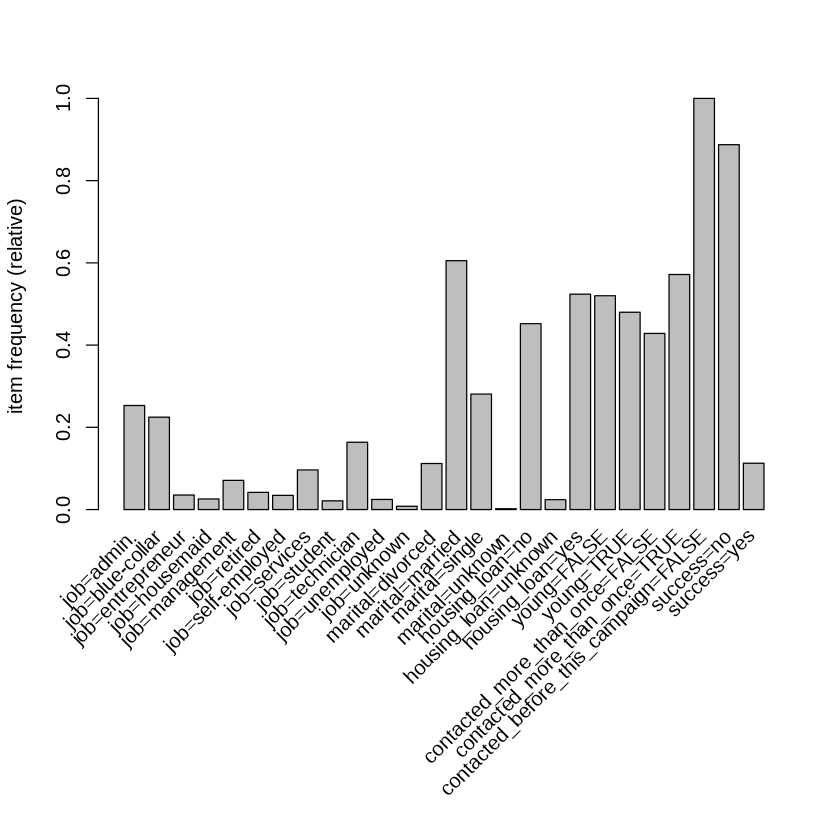

In [11]:
itemFrequency(bankX)
itemFrequencyPlot(bankX)

This is a fairly large dataset, so we will explore only the first 5 observations in the **bankX** transaction matrix:

In [13]:
inspect(bankX[1:5]) 

    items                                  transactionID
[1] {job=housemaid,                                     
     marital=married,                                   
     housing_loan=no,                                   
     young=FALSE,                                       
     contacted_more_than_once=FALSE,                    
     contacted_before_this_campaign=FALSE,              
     success=no}                                       1
[2] {job=services,                                      
     marital=married,                                   
     housing_loan=no,                                   
     young=FALSE,                                       
     contacted_more_than_once=FALSE,                    
     contacted_before_this_campaign=FALSE,              
     success=no}                                       2
[3] {job=services,                                      
     marital=married,                                   
     housing_loan=yes,         

We can now use **apriori()** to generate a set of rules with, e.g. **support** over 0.006 and **confidence** over 0.32, and trying to predict who was successfully signed up for a term deposit:

In [14]:
rules <- apriori(bankX, parameter=list(support=0.006, confidence=0.32), appearance=list(rhs="success=yes"))
rules

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.32    0.1    1 none FALSE            TRUE       5   0.006      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 247 

set item appearances ...[1 item(s)] done [0.00s].
set transactions ...[26 item(s), 41188 transaction(s)] done [0.02s].
sorting and recoding items ... [25 item(s)] done [0.00s].
creating transaction tree ... done [0.02s].
checking subsets of size 1 2 3 4 5 6 7 done [0.00s].
writing ... [4 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


set of 4 rules 

It worked but to get to see the 4 generated rules, we need to use the **inspect()** function:

In [16]:
inspect(rules)

    lhs                                       rhs               support confidence   coverage     lift count
[1] {job=student,                                                                                           
     marital=single}                       => {success=yes} 0.006409634  0.3203883 0.02000583 2.843999   264
[2] {job=student,                                                                                           
     marital=single,                                                                                        
     young=TRUE}                           => {success=yes} 0.006312518  0.3233831 0.01952025 2.870582   260
[3] {job=student,                                                                                           
     marital=single,                                                                                        
     contacted_before_this_campaign=FALSE} => {success=yes} 0.006409634  0.3203883 0.02000583 2.843999   264
[4] {job=student,  

We can visualize the results to make them easier to understand:

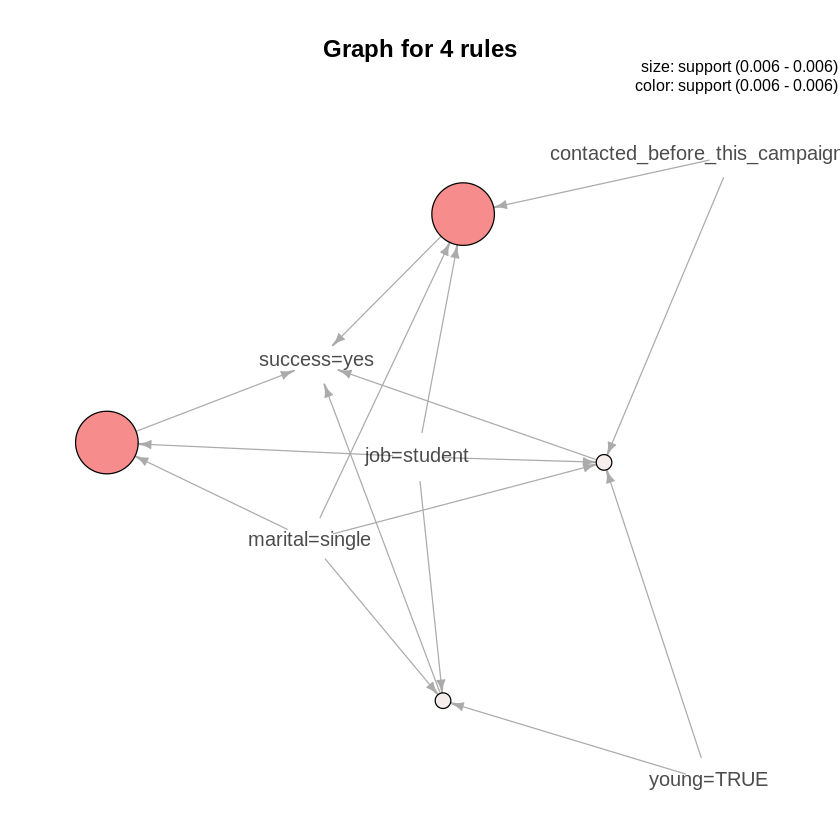

In [19]:
library(arulesViz)
plot(rules,method="graph",shading="support")